## Module 4 Project Submission

Please fill out:
* Student name: Andro Tikvica
* Student pace: Self Paced
* Scheduled project review date/time: 08/10/2021 16:30 GMT
* Instructor name: Jeff Herman
* Blog post URL: 


## Description/Intro

The topic of this project is to answer this question:

**What are the best zipcodes to invest in in Hawaii?**

To measure this we will be focusing on Return on Investment (ROI) as the primary investment. ROI is used to measure the profitability of an event or investment and works on a relative basis (Amount Gained minus Amount Spent) divided by Amount Spent. This means that the absolute value of the property is not relevant for our investment decisions. If it turns out that surf shacks have the highest potential return, we will still recommend them. 


In [391]:
# Primary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# AutoCorrelation Plotting
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
from pmdarima.arima import auto_arima
import itertools
import statsmodels.tsa.api as tsa

In [10]:
# import dataset
zillow_raw = pd.read_csv('time-series\zillow_data.csv')
zillow = zillow_raw.copy()

print(zillow.shape)
zillow.head()

(14723, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Looking at all states would be computationally expensive, may be worth trying at the end but for now, let's try to identify a state that we can start with. The following table will show the number of Zipcodes, Cities, Metro Areas, and Counties that we have data for in this dataset. We want to minimize the number of zipcodes while still maintaining enough variety in zipcodes to have a choice

In [11]:
# Let's see what's a natural way to break down the dataset
breakdown = pd.DataFrame(columns=['State', 'Zipcodes', 'Cities', 'Metro', 'CountyName'])

# Set states
breakdown['State'] = zillow['State'].unique()
breakdown['Zipcodes'] = [zillow['RegionName'][zillow['State'] == i].nunique() for i in breakdown['State']]
breakdown['Cities'] = [zillow['City'][zillow['State'] == i].nunique() for i in breakdown['State']]
breakdown['Metro'] = [zillow['Metro'][zillow['State'] == i].nunique() for i in breakdown['State']]
breakdown['CountyName'] = [zillow['CountyName'][zillow['State'] == i].nunique() for i in breakdown['State']]

breakdown

,State,Zipcodes,Cities,Metro,CountyName
0,IL,547,449,23,43
1,TX,989,540,60,174
2,NY,1015,717,21,53
3,CA,1224,677,31,51
4,FL,785,401,28,57
5,TN,404,316,26,72
6,NC,428,314,35,61
7,GA,345,256,32,79
8,DC,18,1,1,1
9,MO,319,245,24,71


**Seperating out one State**

Hawaii seems like a great choice because it has more 60 zicpodes and 48 cities, making it concentrated but sufficiently varied, and would an amazing place to live. We will remove all superfluous columns so we can focus on Zipcode data.


In [12]:
# Seperate out Hawaii
HI = zillow[zillow['State'] == 'HI']

# How many metro areas
print(f" Hawaii Metro Areas: {HI.Metro.unique()}")

HI = HI.drop(['RegionID','City','State','Metro','CountyName', 'SizeRank'], axis = 1)

# Preview table
HI.head()

 Hawaii Metro Areas: ['Urban Honolulu' 'Hilo' 'Kahului' 'Kapaa']


,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
515,96815,289600.0,291200.0,292700.0,294200.0,295700.0,297100.0,298600.0,299800.0,300900.0,...,987400,982100,975000,972600,969300,970200,973100,980900,999800,1019400
532,96706,233000.0,235100.0,236900.0,238400.0,239500.0,240200.0,240500.0,240200.0,239900.0,...,640600,642800,645700,649000,651500,655900,661200,664600,665600,666300
671,96797,245500.0,247900.0,250000.0,251600.0,252600.0,253100.0,253000.0,252400.0,251700.0,...,667200,668600,669700,672100,674800,679500,684700,687900,689300,690600
711,96720,129800.0,131000.0,132000.0,132900.0,133500.0,133800.0,133900.0,133600.0,133300.0,...,310300,310600,312800,316100,318600,319200,318700,319500,322300,324500
714,96817,291800.0,291700.0,291200.0,290600.0,289800.0,288800.0,287800.0,286600.0,285600.0,...,897300,900200,903500,904600,901900,905100,914300,925100,934400,940400


**Wide to Long Format**

We need to change the equations to work for timeseries models by changing the format, setting the dates as datetime formats and setting those new dates as the index. 

In [13]:
# Modified helper function to make the necesary changes
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Date'] = pd.to_datetime(melted['Month'], infer_datetime_format=True)
    melted.drop('Month', axis = 1, inplace = True)
    melted = melted.dropna(subset=['MeanValue'])
    melted.set_index('Date', inplace = True)
    return melted

In [14]:
HIm = melt_data(HI)
print(HIm.shape)
HIm.head(2)

(15011, 2)


,RegionName,MeanValue
Date,,
1996-04-01,96815,289600.0
1996-04-01,96706,233000.0


In [15]:
HIm_yr = HIm.copy()

# Change date format to year
HIm_yr.index = pd.DatetimeIndex(HIm_yr.index).year

# Use groupby to find the mean
HIm_yr = HIm_yr.groupby(['Date', 'RegionName']).mean().reset_index()

# Drop empty columns - shouldn't be any
HIm_yr = HIm_yr.dropna(subset=['MeanValue'])

# Set date as index because we reset_index above
HIm_yr.set_index('Date', inplace = True)

print(HIm_yr.shape)
HIm_yr.head(2)

(1309, 2)


,RegionName,MeanValue
Date,,
1996,96701,258633.333333
1996,96703,121466.666667


**Plotting Average Prices**

What these two charts show us is that we may be able to run an analysis on more states quicker if we average the data out by year we still get relatively accurate results while reducing run time. But for the first analysis we will use the full monthly data.

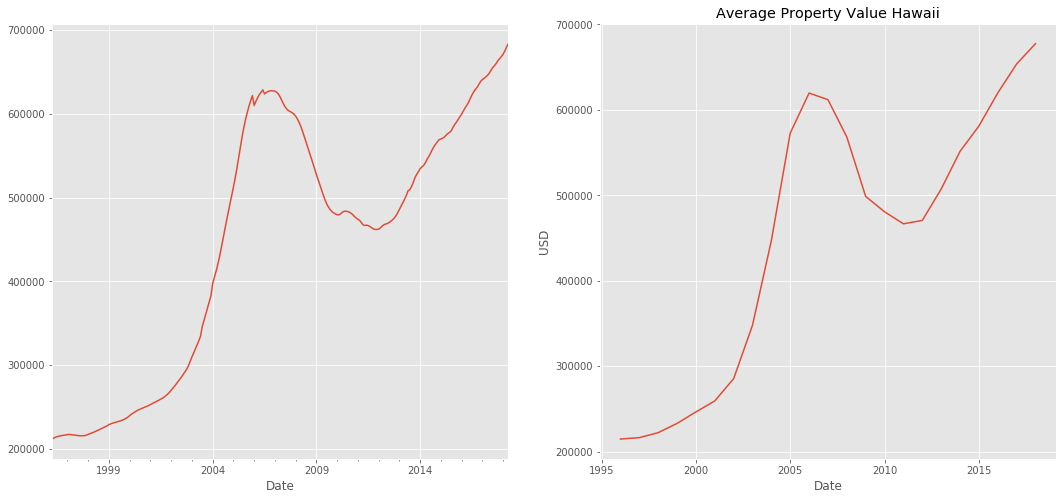

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

#Average statewide property value
HIm.groupby('Date')['MeanValue'].mean().plot(ax=axes[0])
plt.title('Average Property Value Hawaii')
plt.xlabel('Date')
plt.ylabel('USD')

HIm_yr.groupby('Date')['MeanValue'].mean().plot(ax=axes[1])

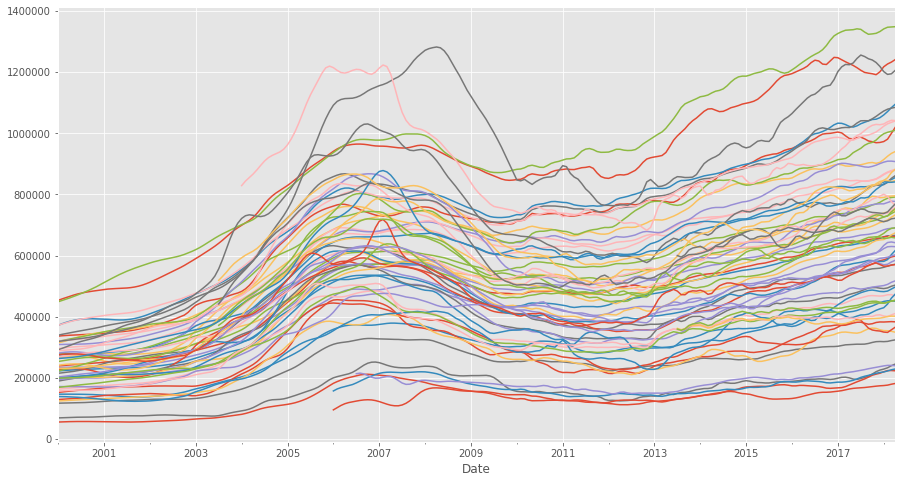

In [17]:
# Visualize property values of indiviudal zipcodes
for zipcode in HIm.RegionName.unique():
    temp_df = HIm[HIm.RegionName == zipcode]
    temp_df['2000':]['MeanValue'].plot(figsize=(15,8), label=zipcode)

Generally, all zipcodes in Hawaii follow the economy, no significant outliers. Let's take a look at the disparity in average property value. This is more of a curiosity and will help us see what we are working with. Realistically we are looking at more expensive real estate. 

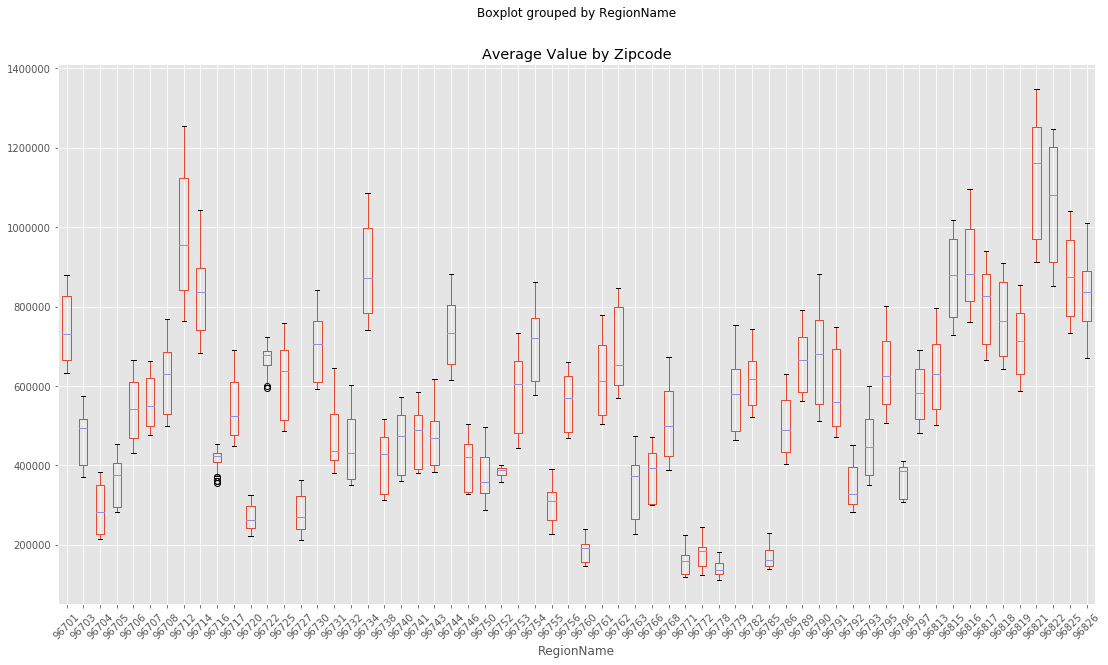

In [154]:
plot = HI_2011.boxplot(by='RegionName', column=['MeanValue'], figsize=(18,10))
fig = plot.get_figure()
plt.title('Average Value by Zipcode')
plt.xticks(rotation=45)
fig.savefig("images/boxplot.png")
plt.show()

In [402]:
print(f"The Average Property Value in 2018: ${round(HI_2011['2018'].MeanValue.mean(),2)}")
print(f"Standard Deviation: {round(HI_2011['2018'].MeanValue.std(),2)}")

The Average Property Value in 2018: $677376.61
Standard Deviation: 262250.18


**Filtering out the Crash**

We are going to separate out the data from the last ten years for the initial analysis to remove the impact of the 2008 Housing crash and the volatility that followed.

**CONSIDER ADDING A SECOND FILTER OF PERFORMANCE THROUGH THE CRASH TO PICK AREAS THAT MAY PERFORM WELL THROUGH ANOTHER CRASH**

In [186]:
HI_2011 = HIm['2011':]
HI_2011.head(2)

month_avg = HI_2011.groupby('Date')['MeanValue'].mean()

In [219]:
temp_dict = {}
for i in HIm['RegionName'].unique():
    temp_dict[i] = HIm.groupby('RegionName').get_group(i).sort_index()['MeanValue']
    
hi_zips = pd.DataFrame(temp_dict)
hi_zips.head(2)

,96815,96706,96797,96720,96817,96789,96744,96822,96816,96818,...,96708,96790,96779,96714,96771,96785,96760,96722,96752,96716
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,289600.0,233000.0,245500.0,129800.0,291800.0,274900.0,257900.0,403300.0,299600.0,245300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-01,291200.0,235100.0,247900.0,131000.0,291700.0,277300.0,261000.0,402100.0,304100.0,245300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Three Year ROI


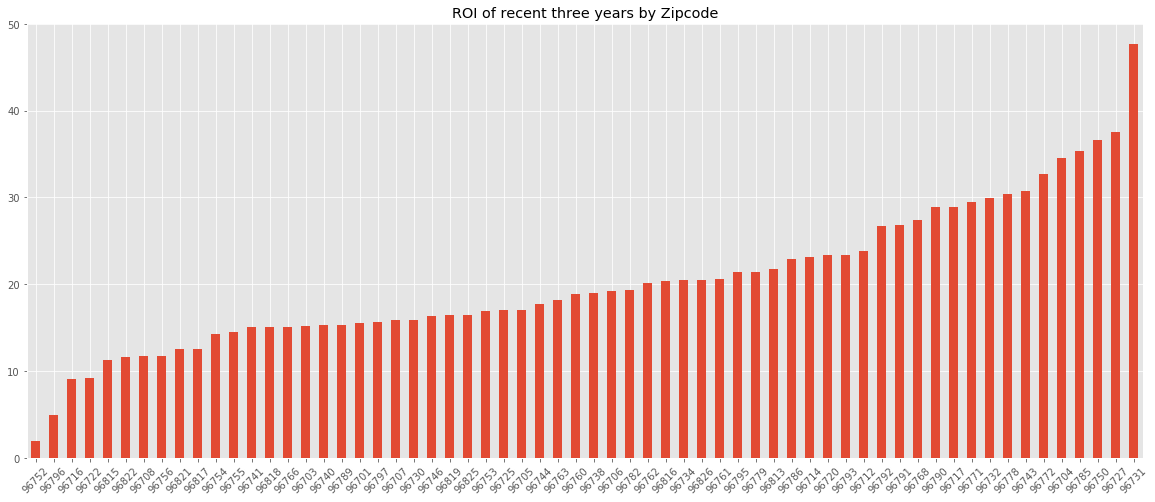

In [220]:
((((hi_zips.iloc[-1, :] - hi_zips.iloc[-37, :]) / hi_zips.iloc[-37, :]).sort_values()) * 100).plot(
    kind='bar', figsize=(20, 8), title='ROI of recent three years by Zipcode')
plt.tick_params('x', labelrotation=45)

Every single Zipcode in Hawaii has a positive ROI over a three year period.

Best Performing Zipcodes:

- 96731
- 96727
- 96750

Worst Performing Zipcodes:

- 96752
- 96796
- 96716

# Model

In [221]:
# List of all Zipcodes
zipcodes = hi_zips.columns

# Pick a Random test zipcode
test_zip = zipcodes[4]

Original


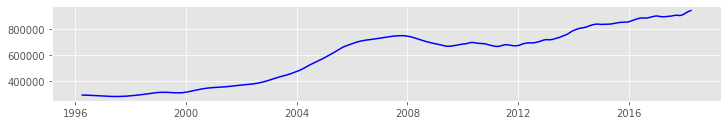

Trend


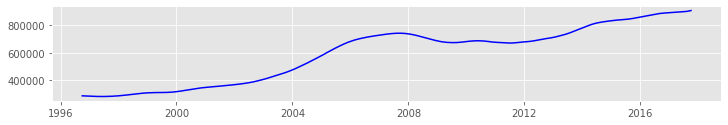

Seasonality


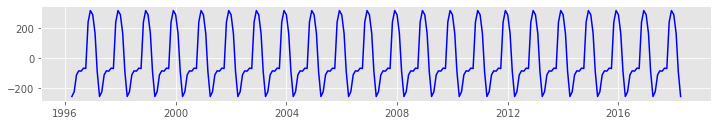

Residuals


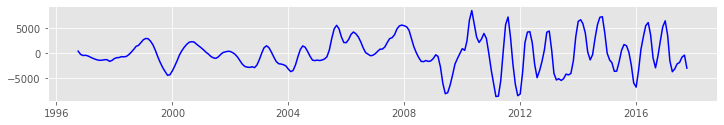

In [223]:
decomposition = sm.tsa.seasonal_decompose(hi_zips[test_zip], model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
print('Original')
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(hi_zips[test_zip], label='Original', color='blue')
plt.show()
print('Trend')
plt.figure(figsize=(12,8))
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.show()
print('Seasonality')
plt.figure(figsize=(12,8))
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.show()
print('Residuals')
plt.figure(figsize=(12,8))
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.show()

Visible upward trend with clear seasonality. 

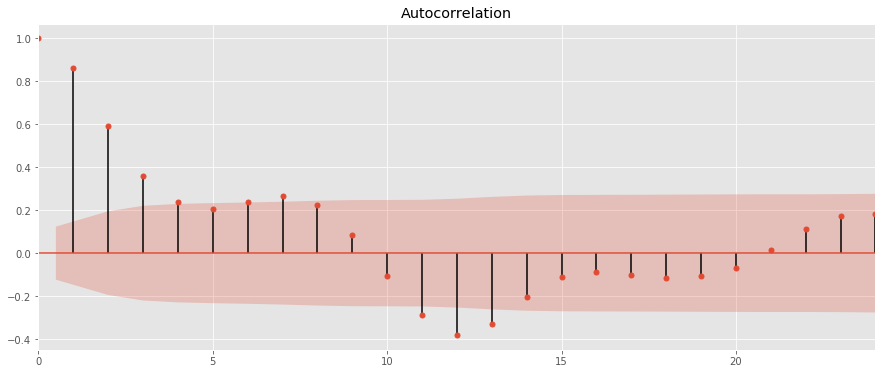

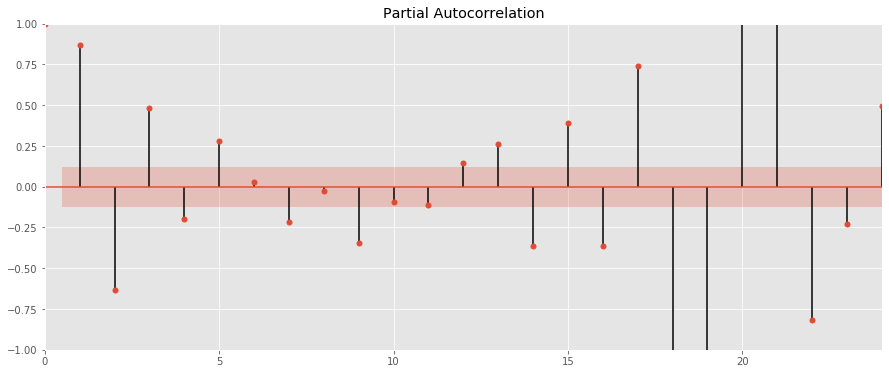

In [275]:
plot_acf(hi_zips[test_zip].diff(12).diff(1).dropna()); plt.xlim(0,24); plt.show()
plot_pacf(hi_zips[test_zip].diff(12).diff(1).dropna()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

**Check for Stationarity**

In [277]:
def stationary_check(ts):
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    
    fig = plt.plot(figsize=(16,8))
    plt.plot(ts)
    plt.plot(roll_mean, color = 'green')
    plt.plot(roll_std, color='orange')
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Test Statistic                  -2.839243
p-value                          0.052883
#Lags Used                      16.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


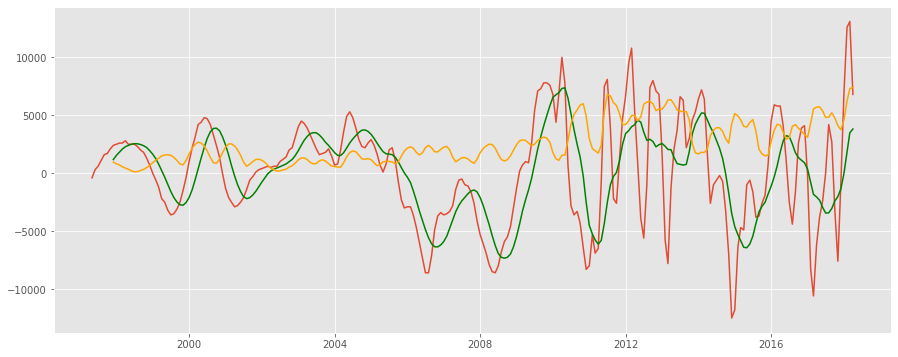

In [284]:
stationary_check(hi_zips[test_zip].diff(12).diff(1).dropna())

P-Value just about allows us to reject the null hypothesis. The time series is stationary. 
Worked best with diff(12) and diff(1) combined.

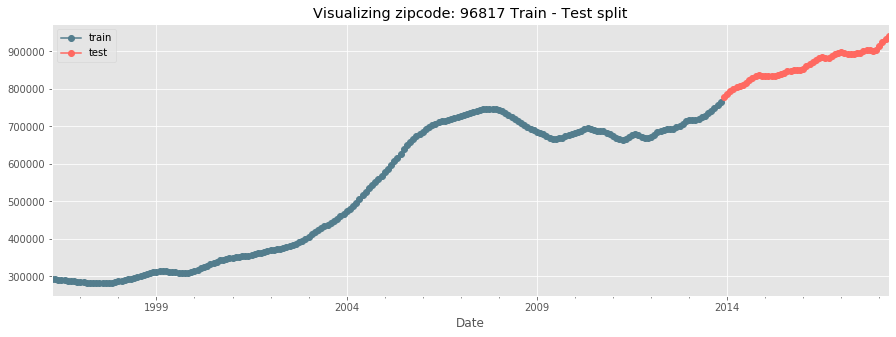

In [296]:
# Train test split
train_size = 0.8
split_idx = round(len(hi_zips[test_zip].dropna()) * train_size)

# Split
train = hi_zips[test_zip].dropna().iloc[:split_idx]
test = hi_zips[test_zip].dropna().iloc[split_idx:]

# Visualize
fig, ax = plt.subplots(figsize=(15, 5))
kws = dict(ax=ax, marker='o')
train.plot(**kws, label='train',color='#537d8d')
test.plot(**kws, label='test',color='#ff6961')
ax.legend()
plt.title(f'Visualizing zipcode: {test_zip} Train - Test split')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                  212
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2071.190
Date:                Fri, 08 Oct 2021   AIC                           4144.381
Time:                        04:37:58   BIC                           4147.733
Sample:                    04-01-1996   HQIC                          4145.736
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.957e+07   1.97e+06      9.924      0.000    1.57e+07    2.34e+07
===================================================================================
Ljung-Box (L1) (Q):                 190.47   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               5.20   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

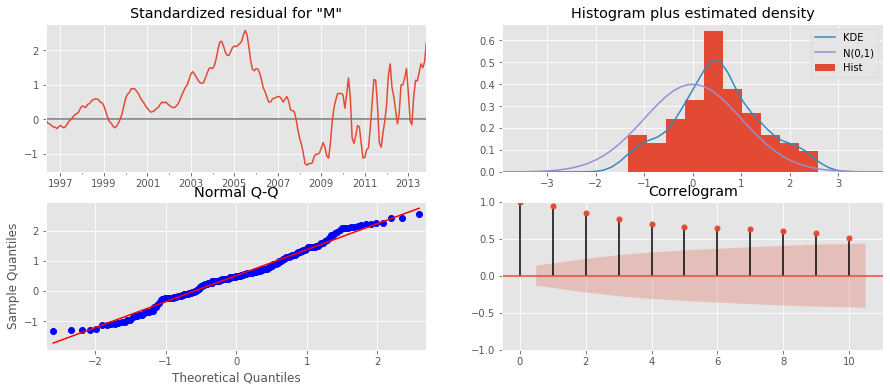

In [415]:
# Baseline model
model = SARIMAX(HIm[HIm['RegionName'] == 96817].MeanValue.iloc[:round(len(HIm[HIm['RegionName'] == 96817])*.8)],order=(0,1,0),).fit()
display(model.summary())
model.plot_diagnostics()
plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8674      0.029     29.597      0.000       0.810       0.925
ma.L1          0.2570      0.015     17.114      0.000       0.228       0.286
ar.S.L12      -0.5365      0.056     -9.600      0.000      -0.646      -0.427
ma.S.L12      -0.0082      0.032     -0.254      0.800      -0.071       0.055
sigma2      2.742e+06   1.76e+05     15.571      0.000     2.4e+06    3.09e+06


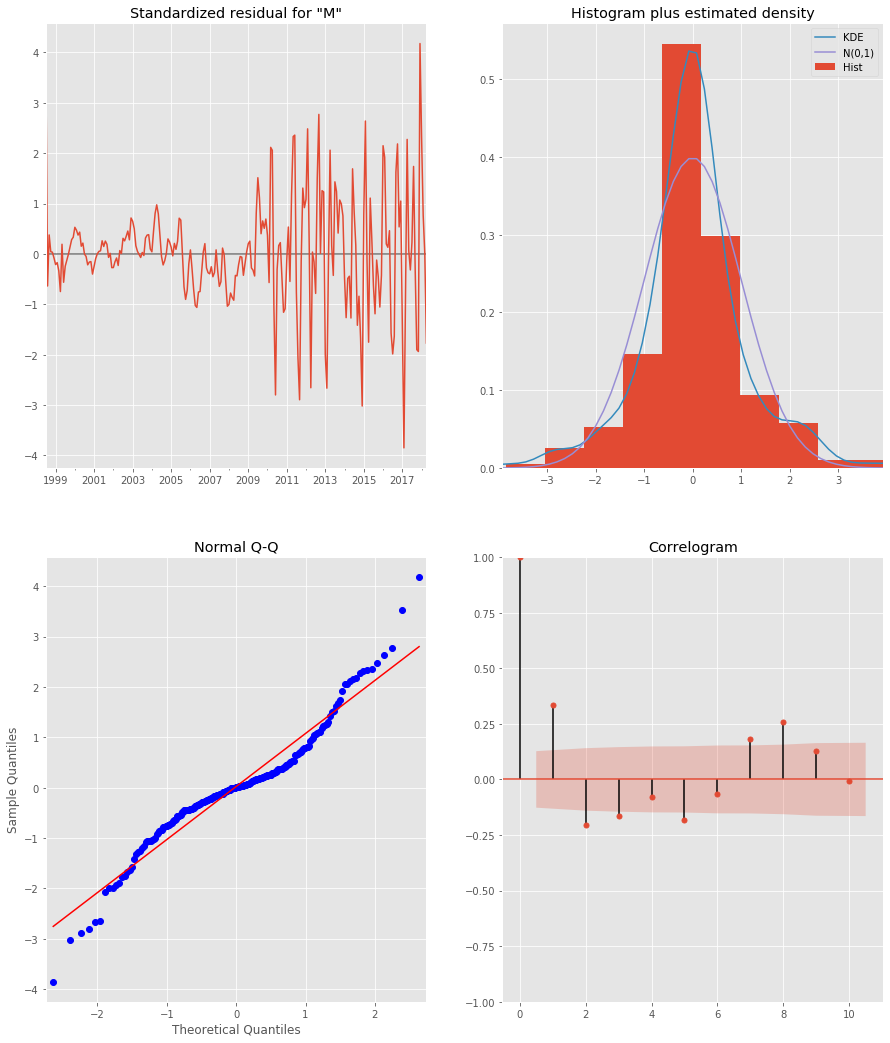

In [411]:
# Try Different Orders and Add Seasonal Orders
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(HIm[HIm['RegionName'] == 96817].MeanValue, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

**Parameter Tuning**

In [256]:
# Create a dict of each Zipcodes data
HI_dict = {}
for zipc in hi_zips.columns:
    HI_dict[zipc] = hi_zips[zipc]
    
# Set up list of all possible p/d/q values
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [258]:
# Find AIC results for every parameter combination
AIC = []
for zipcode in HI_dict.keys():
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(HI_dict[zipcode], order=param, 
                                                seasonal_order=param_seasonal, enforce_stationarity=False, 
                                                enforce_invertibility=False)
                results = mod.fit()
                AIC.append([zipcode, param, param_seasonal, np.abs(results.aic)])
            except:
                continue


In [260]:
# Turn the list into a DF
AIC_df = pd.DataFrame(AIC, columns = ["zip","pdq", "pdqs", 'aic'])

# Sort by ascending AIC values: lower is better
AIC_df.sort_values('aic', ascending = True).groupby('zip')

# Create a dict of only best performing params 
AIC_dict = {}
for i, g in AIC_df.sort_values('aic', ascending = True).groupby('zip'):
    AIC_dict[i] = g
    AIC_dict[i] = AIC_dict[i].iloc[0]

**Best Model for Test Zip**

In [315]:
best_model = tsa.SARIMAX(train,
                         order = AIC_dict[test_zip].pdq,
                         seasonal_order = AIC_dict[test_zip].pdqs, 
                      maxiter=500, enforce_invertibility=False).fit()

In [318]:
forecast = best_model.get_forecast(steps=len(test))
pred_df_test = pd.DataFrame([forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], forecast.predicted_mean]).T
pred_df_test.columns = ["lower", 'upper', 'prediction']

In [322]:
best_model_all = tsa.SARIMAX(hi_zips[test_zip],
                                 order = AIC_dict[test_zip].pdq,
                                 seasonal_order = AIC_dict[test_zip].pdqs, 
                                 maxiter=500, enforce_invertibility=False).fit()
forecast = best_model_all.get_forecast(steps=24)
pred_df = pd.DataFrame([forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], forecast.predicted_mean]).T
pred_df.columns = ["lower", 'upper', 'prediction']

In [327]:
mean_roi = (pred_df[-1:]['prediction'][0] - test[-1:][0])/test[-1:][0]
lower_roi = (pred_df[-1:]['lower'][0] - test[-1:][0])/test[-1:][0]
upper_roi = (pred_df[-1:]['upper'][0] - test[-1:][0])/test[-1:][0]
std_roi = np.std([lower_roi, upper_roi])

print(f"Zipcode: {test_zip}")
print(f"""Mean ROI: {round(mean_roi * 100, 2)}%
Lower ROI: {round(lower_roi * 100, 2)}%
Upper ROI: {round(upper_roi * 100, 2)}%
STD ROI: {round(std_roi * 100, 2)}%""")

Zipcode: 96817
Mean ROI: 11.0%
Lower ROI: 3.07%
Upper ROI: 18.93%
STD ROI: 7.93%


In [347]:
roi_df = pd.DataFrame([{
            'zipcode': test_zip,
            'mean_forecasted_roi': mean_roi,
            'lower_forecasted_roi': lower_roi,
            'upper_forecasted_roi': upper_roi,
            'std_forecasted_roi': std_roi}])

**For All the Zipcodes**

In [361]:
def find_roi(ts, params, train_size=0.8):
    '''Enter timeseries and return dataframe containing ROI's for each zipcode
    '''
    # DF to save results
    ROI_df = pd.DataFrame(columns=['zipcode', 'mean_roi', 'lower_roi', 'upper_roi', 'std_roi'])
    
    for zipc in ts.columns:

        # Train test split
        split_idx = round(len(ts[zipc].dropna()) * train_size)
        
        # Split
        train = ts[zipc].dropna().iloc[:split_idx]
        test = ts[zipc].dropna().iloc[split_idx:]
        
        #Best model using params input
        best_model = tsa.SARIMAX(train,
                         order = params[zipc].pdq,
                         seasonal_order = params[zipc].pdqs, 
                      maxiter=500, enforce_invertibility=False).fit()
        
        # Forecast Test Data
        forecast = best_model.get_forecast(steps=len(test))
        pred_df_test = pd.DataFrame([forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], forecast.predicted_mean]).T
        pred_df_test.columns = ["lower", 'upper', 'prediction']
        
        # Future Best Model
        best_model_future = tsa.SARIMAX(ts[zipc],
                                 order = params[zipc].pdq,
                                 seasonal_order = params[zipc].pdqs, 
                                 maxiter=500, enforce_invertibility=False).fit()
        forecast = best_model_future.get_forecast(steps=24)
        pred_df = pd.DataFrame([forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], forecast.predicted_mean]).T
        pred_df.columns = ["lower", 'upper', 'prediction']
        
        # Calculate ROI
        mean_roi = (pred_df[-1:]['prediction'][0] - test[-1:][0])/test[-1:][0]
        lower_roi = (pred_df[-1:]['lower'][0] - test[-1:][0])/test[-1:][0]
        upper_roi = (pred_df[-1:]['upper'][0] - test[-1:][0])/test[-1:][0]
        std_roi = np.std([lower_roi, upper_roi])
        
        temp_dict = {
            'zipcode': str(zipc),
            'mean_roi': mean_roi,
            'lower_roi': lower_roi,
            'upper_roi': upper_roi,
            'std_roi': std_roi}
        
        ROI_df = ROI_df.append(temp_dict, ignore_index = True)
        
    return ROI_df
        

In [362]:
# Run the function above
ROI_df = find_roi(hi_zips, AIC_dict)

In [371]:
# Order Results by mean ROI
roi_final = ROI_df.sort_values('mean_roi', ascending=False).iloc[1:]

In [390]:
# Print out results so I don't have to type it
print("Best Three Zipcodes:")
for i in [0,1,2,3]:
    if i >= 0:
        print(f"{i + 1}. {roi_final.zipcode.iloc[i]} - Mean ROI: {round(roi_final.mean_roi.iloc[i]*100,2)}%\tBear Case: {round(roi_final.lower_roi.iloc[i]*100,2)}%\tBull Case: {round(roi_final.upper_roi.iloc[i]*100,2)}%")
print("\nWorst Three Zipcodes:")
for i in [-1,-2,-3,-4]:
    print(f"{-1*i}. {roi_final.zipcode.iloc[i]} - Mean ROI: {round(roi_final.mean_roi.iloc[i]*100,2)}%\tBear Case: {round(roi_final.lower_roi.iloc[i]*100,2)}%\tBull Case: {round(roi_final.upper_roi.iloc[i]*100,2)}%")

Best Three Zipcodes:
1. 96771 - Mean ROI: 35.9%	Bear Case: -15.45%	Bull Case: 87.25%
2. 96763 - Mean ROI: 31.1%	Bear Case: 3.12%	Bull Case: 59.08%
3. 96772 - Mean ROI: 28.65%	Bear Case: 1.33%	Bull Case: 55.97%
4. 96743 - Mean ROI: 21.11%	Bear Case: 0.77%	Bull Case: 41.46%

Worst Three Zipcodes:
1. 96760 - Mean ROI: -18.33%	Bear Case: -61.3%	Bull Case: 24.64%
2. 96779 - Mean ROI: -5.44%	Bear Case: -35.73%	Bull Case: 24.86%
3. 96785 - Mean ROI: -4.63%	Bear Case: -47.13%	Bull Case: 37.87%
4. 96752 - Mean ROI: -0.24%	Bear Case: -22.13%	Bull Case: 21.64%


In [34]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred


pred_df = forecast_to_df(forecast,96815)

In [35]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

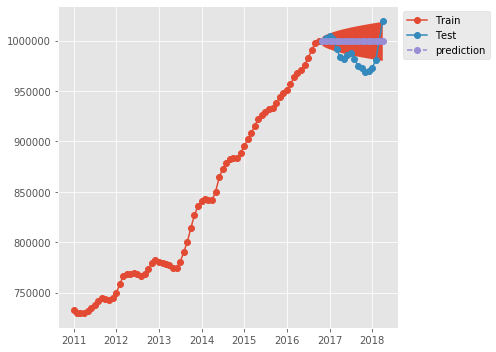

In [36]:
plot_train_test_pred(train,test,pred_df)
plt.show()